In [1]:
import os
os.chdir('./1-3/')
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from testCases import *
from planar_utils import *

np.random.seed(1)

In [2]:
X, Y = load_planar_dataset()
print(f'X.shape = {X.shape}')
print(f'Y.shape = {Y.shape}')

X.shape = (2, 400)
Y.shape = (1, 400)


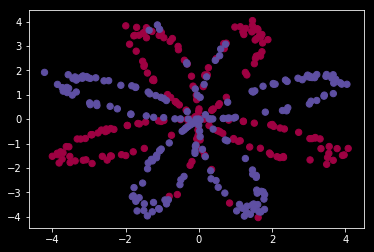

In [3]:
plt.scatter(X[0], X[1], s=40, c=np.squeeze(Y), cmap=plt.cm.Spectral)
# c: 用数值表示颜色, cmap: 数值到颜色的映射关系

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


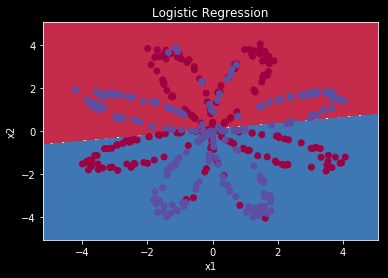

In [4]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T, Y.T)
plot_decision_boundary(clf.predict, X, Y)
plt.title('Logistic Regression')
plt.show()

In [5]:
print('逻辑回归准确率', clf.score(X.T, Y.T))
# 对输入X正规化缩放
X = X / 5
# 数据集中Y.dtype是'uint8'类型, 使得-Y取值变成(0, 255), 必须要用astype()方法转化成'float64'
# 记住使用数据前一定先检查数据的类型!!!!!!!!!!!
Y = Y.astype(np.float64)
print(Y.shape, Y.dtype, '\n', Y)

逻辑回归准确率 0.47
(1, 400) float64 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1

In [6]:
def tanh(x):
    s = np.tanh(x)
    return s

def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

def ReLU(x):
    s = np.maximum(x, 0)
    return s



class Layer(object):


    def __init__(self, n_input, n_layer, activate, name=None):
        self.n = n_layer
        self.name = name
        self.activate = activate
        self.X = None
        self.W = np.random.randn(n_layer, n_input) * 1e-4
        self.b = np.zeros((n_layer, 1))
        self.Z = None
        self.A = None
        self.dA = None
        self.dZ = None
        self.dW = None
        self.db = None
        self.dX = None

    def get_W(self):
        return self.W

    def get_b(self):
        return self.b

    def get_A(self):
        return self.A

    def get_dX(self):
        return self.dX    

    def fwprop(self, X):
        self.X = X
        self.Z = np.dot(self.W, self.X) + self.b
        self.A = self.activate(self.Z)

    def bkprop(self, dA, alpha):
        self.dA = dA
        if self.activate == tanh:
            self.dZ = self.dA * (1 - self.A**2)
        elif self.activate == sigmoid:
            self.dZ = self.dA * self.A * (1 - self.A)
        elif self.activate == ReLU:
            self.dZ = self.dA * (self.A > 0)
        else:
            print('Wrong activate function!')
        self.dX = np.dot(self.W.T, self.dZ)
        self.dW = np.dot(self.dZ, self.X.T)
        self.db = np.mean(self.dZ, axis=1).reshape((self.n, 1))
        self.W -= alpha * self.dW
        self.b -= alpha * self.db



class Model(object):


    def __init__(self, X_train, Y_train, alpha=0.005, loops=2000):
        self.X = X_train
        self.Y = Y_train
        self.alpha = alpha
        self.loops = loops
        self.L = 0
        self.layers = []
        self.layers_reverse = []
        self.A = None
        self.J = None
        self.J_list = []

    def add_layer(self, n_input, n_layer, activate, name=None):
        self.L += 1
        new_layer = Layer(n_input, n_layer, activate, name=name)
        self.layers.append(new_layer)
        self.layers_reverse = self.layers.copy()
        self.layers_reverse.reverse()
        return new_layer

    def fwprop(self):
        input_ = self.X
        for layer in self.layers:
            layer.fwprop(input_)
            input_ = layer.get_A()

    def compute_J(self):
        self.A = self.layers[-1].get_A()
        # 防止出现log(0)等于nan的情况, 每次log()内加上极小正数
        self.J = (-self.Y * np.log(self.A + 1e-10) - (1 - self.Y) * np.log(1 - self.A + 1e-10)).mean()

    def bkprop(self):
        # 防止出现x / 0等于nan的情况, 每次 / 分母加上极小正数
        dA = -self.Y / (self.A +10e-10) + (1 - self.Y) / (1 - self.A +10e-10)
        for layer in self.layers_reverse:
            layer.bkprop(dA, alpha=self.alpha)
            dA = layer.get_dX()

    def train(self):
        for i in range(self.loops):
            self.fwprop()
            self.compute_J()
            self.bkprop()
            j = i + 1
            if j%50 == 0:
                self.J_list.append(self.J)
                print(f'第{j}次迭代的损失值: {self.J}')

    def predict(self, X_test):
        for layer in self.layers:
            layer.fwprop(X_test)
            X_test = layer.get_A()
        return X_test

    def score(self, X_test, Y_test):
        #仅实现二分类问题
        Y_predict = self.predict(X_test)
        result = (Y_predict > 0.5) == Y_test
        acc = result.mean()
        return acc

    def plot_loss(self):
        plt.plot(self.J_list)
        plt.xlabel('steps per 50')
        plt.ylabel('loss')
        plt.title('loss circle')
        plt.show()

    def plot_bound(self):
        plot_decision_boundary(lambda x: self.predict(x.T), self.X, self.Y)
        plt.title('Neual Network Decision Boundary')
        plt.show()

In [7]:
model = Model(X, Y, alpha=0.005, loops=4000)
layer1 = model.add_layer(2, 4, tanh, name='Hidden Layer')
layer2 = model.add_layer(4, 1, sigmoid, name='Output Layer')
model.train()

第50次迭代的损失值: 0.6931451366768868
第100次迭代的损失值: 0.6896262383012168
第150次迭代的损失值: 0.6746715709881397
第200次迭代的损失值: 0.6732345921799455
第250次迭代的损失值: 0.6658455870523978
第300次迭代的损失值: 0.6436301670942359
第350次迭代的损失值: 0.6162112922281634
第400次迭代的损失值: 0.4892910390188699
第450次迭代的损失值: 0.4076569339878829
第500次迭代的损失值: 0.3796577214479783
第550次迭代的损失值: 0.36565202336167346
第600次迭代的损失值: 0.35685183315730057
第650次迭代的损失值: 0.3505770199545333
第700次迭代的损失值: 0.3457519893292033
第750次迭代的损失值: 0.34185582274027554
第800次迭代的损失值: 0.3386014968848338
第850次迭代的损失值: 0.3358158054956983
第900次迭代的损失值: 0.3333868594054913
第950次迭代的损失值: 0.331238342277532
第1000次迭代的损失值: 0.32931579385296145
第1050次迭代的损失值: 0.3275788372920687
第1100次迭代的损失值: 0.32599655497315466
第1150次迭代的损失值: 0.32454462132748957
第1200次迭代的损失值: 0.3232034584451332
第1250次迭代的损失值: 0.3219570096151092
第1300次迭代的损失值: 0.32079189979998257
第1350次迭代的损失值: 0.3196968474852699
第1400次迭代的损失值: 0.3186622464629795
第1450次迭代的损失值: 0.31767986762188705
第1500次迭代的损失值: 0.3167426494849653
第1550次迭代的损失值: 0.3158445

In [8]:
accuracy = model.score(X, Y)
print(accuracy)

0.875


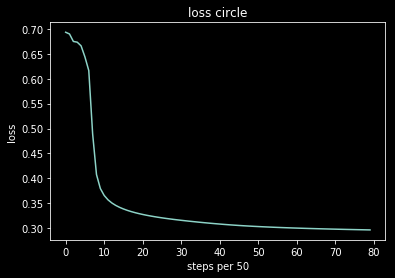

In [9]:
model.plot_loss()

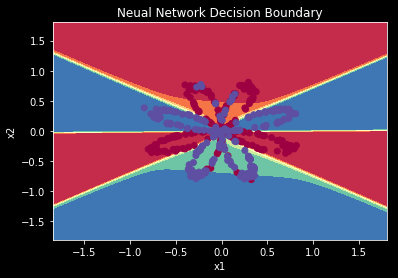

In [10]:
model.plot_bound()

In [11]:
print('layer1:', model.layers[0].name)
print('layer2:', model.layers[1].name)

layer1: Hidden Layer
layer2: Output Layer
